In [1]:
# 필요한 기본 패키지 준비

# 데이터 처리 필요 패키지
import numpy as np
import pandas as pd
import datetime as dt
import math
# 다중공선성(multicollinearity)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 시각화 필요 패키지
%matplotlib inline
from plotnine import *
import folium
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns


# Machine Learning 분석 환경 준비

# 전처리, 스케일링
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# 선형회귀분석
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm

# # GAM 일반화가법모형
# # LinearGAM, LogisticGAM, PoissonGAM, GammaGAM, InvGuss
# from pygam import LinearGAM, LogisticGAM, PoissonGAM, GammaGAM

# # Boosting

#데이터셋 분리
from sklearn.model_selection import train_test_split

# 한글 처리
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# jupyter notebook에서 warning 무시하기
import warnings
warnings.filterwarnings("ignore")

In [2]:
def loadData():
    # 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
    gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
    lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
    w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
    sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])
    return gs, lv, w, sns_all
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d, before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lin_model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lin_model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(lin_model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df
#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif
#########################################################################

def chiCheck_byP(df, col1, col2):
    chis = stats.chisquare(df[col1], df[col2])
    return chis

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [3]:
def allAtOnce(sales_df, 
              weather_df, 
              item, 
              sales_cols=['date','bor_nm','gender','age_cd','category'],
              w_cols=['date','temp','humid','wind','rain','snow','cloud','sun_time','lgt_time','hpa',
                      'SO2','CO','O3','NO2','PM10','PM25'],
              n_vif_asc=7,
              target='qty'):
    '''
    sales_df = gs/lv데이터만 넣어주세요. 일단위로 종합된 데이터프레임에만 작동합니다.
    weather_df = w데이터만 넣어주세요. 일단위로 종합된 데이터프레임에만 작동합니다.
    item = str객체로, 한개의 물품만 넣어주세요
    w_cols = 기본적으로 'uv'데이터를 제외한 컬럼명들입니다.
    '''
    # 오류발생 어느정도 잡기 위한 부분
    if 'category' not in list(sales_df.columns):
        print('적법한 df를 넣으세요')
        return
    elif item not in list(sales_df.category.unique()):
        print('%s가 df안에 존재 하지 않습니다.'%item)
        return
    
    # GS/lv 서울시만
    sales_seoul = sales_df.loc[sales_df.pvn_nm =='서울특별시']
    w_seoul = weather_df.loc[weather_df['loc']==108]
    sales_seoul_grouped = sales_seoul[sales_cols+[target]].groupby(by=['date','category']).sum().reset_index()
    sales_seoul_grouped_w_item = pd.merge(sales_seoul_grouped.loc[sales_seoul_grouped.category==item], 
                                          w_seoul, on='date', how='left')

    Xy = sales_seoul_grouped_w_item[w_cols+['category',target]]
    
    low_vif_list = lowVIF(Xy,n_vif_asc)
    
    linReg(df=Xy,item=item,cols_using=low_vif_list.features)
    ridgeReg(df=Xy,item=item,cols_using=low_vif_list.features)
    lassoReg(df=Xy,item=item,cols_using=low_vif_list.features)

    cust_F = formulaGen(target=target,ind_features=low_vif_list.features)
    ols_model = sm.OLS.from_formula(cust_F, data=Xy)
    print(ols_model.fit().summary())

In [4]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs, lv, w, sns_all = loadData()
# gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
# lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
# w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
# sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

In [5]:
# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

# 컬럼 이름을 변경하여 Series로 돌려주는 함수
sns_all.columns = changeColNames(sns_all,'.','_')
# ols formula입력시 오류 발생 방지를위해 컬럼명 문자열 내, 마침표(.)가 전부 underscore(_)로 변경
# sns_all.columns

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()
# gs_grouped.tail(2)

w_seoul = w_seoul.drop(columns=['loc','year','month','day','weekday','nth_week'])

In [6]:
# 서울특별시 단위로 df조정(구단위 데이터 합치기)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()
# day_gs_grouped.tail(3)

In [7]:
# '아이스크림'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'day_gs_grouped_w_item'생성
item = '아이스크림'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

In [8]:
ind_vars_w = ['temp','humid','wind','rain','snow','cloud','sun_time','hpa','lgt_time',
              'SO2','CO','O3','NO2','PM10','PM25']
ind_vars_s = ['pm_total', 'health_total','br_total', 'hobby_total','date_total']
# ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time','SO2','CO','O3','NO2','PM10','PM25'
#              ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']
ind_vars = ind_vars_w+ind_vars_s

Xy = day_gs_grouped_w_sns_item.loc[day_gs_grouped_w_sns_item['category']==item,ind_vars+['qty']]
Xy = addDayWeek(Xy)

Xy_2016 = Xy.loc[Xy.day <=366]
Xy_2016_week = Xy_2016.groupby('week').mean().reset_index()
Xy_2016_week = Xy_2016_week[ind_vars+['qty']]

Xy_2017 = Xy.loc[(Xy.day >366) & (Xy.day <=(366+365))]
Xy_2017_week = Xy_2017.groupby('week').mean().reset_index()
Xy_2017_week = Xy_2017_week[ind_vars+['qty']]

Xy_2018 = Xy.loc[(Xy.day >(366+365))]
Xy_2018_week = Xy_2018.groupby('week').mean().reset_index()
Xy_2018_week = Xy_2018_week[ind_vars+['qty']]

Xy_week = Xy.groupby('week').mean().reset_index()
Xy_week = Xy_week[ind_vars+['qty']]


In [9]:
plt.hist(Xy_grouped_week['temp'], bins=5)

NameError: name 'Xy_grouped_week' is not defined

(366, 23) 366
(365, 23) 731
(365, 23) 1096
(1096, 23) 1096


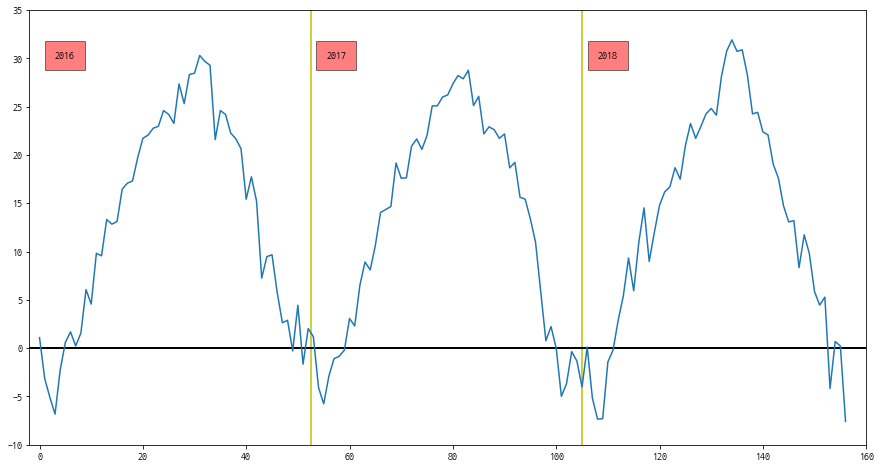

In [10]:
print(Xy_2016.shape,Xy_2016.shape[0])
print(Xy_2017.shape,Xy_2016.shape[0]+Xy_2017.shape[0])
print(Xy_2018.shape,Xy_2016.shape[0]+Xy_2017.shape[0]+Xy_2018.shape[0])
print(Xy.shape,Xy_2016.shape[0]+Xy_2017.shape[0]+Xy_2018.shape[0])
plt.figure(figsize=(15,8))
# plt.grid()
plt.xlim(-2,160)
plt.ylim(-10,35)

plt.text(3, 30, '2016', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
plt.text(3+52.5, 30, '2017', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
plt.text(3+105, 30, '2018', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

plt.plot([52.5,52.5],[-10,35],'y-')
plt.plot([105,105],[-10,35],'y-')

plt.plot([-2,160],[0,0],'k-')
plt.plot([-2,160],[0,0],'k-')
plt.plot([-2,160],[0,0],'k-')

plt.plot(Xy_week['temp'])

plt.show()

In [11]:
# Get dataset
df = day_gs_grouped_w_sns_item.copy()

col_to_use = ['temp', 'cloud', 'wind',
       'humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']
#        'pm_blog', 'pm_twitter', 'pm_news', 'pm_total', 'health_blog',
#        'health_twitter', 'health_news', 'health_total', 'date_blog',
#        'date_twitter', 'date_news', 'date_total', 'br_blog', 'br_twitter',
#        'br_news', 'br_total', 'hobby_blog', 'hobby_twitter', 'hobby_news',
#        'hobby_total']

# vif 최하위 7개
lowV = lowVIF(df,7)
lowV

,VIF_Factor,features
0,11.556777,temp
1,14.535165,cloud
2,17.535649,wind
3,19.096090,PM10
4,19.202700,O3
5,20.777120,lgt_time
6,24.973663,PM25


In [12]:
cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']
week_gs_grouped = gs_seoul[cols_to_keep].copy()
# week_gs_grouped.tail(2)

# '아이스크림'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
item = '아이스크림'
week_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()
week_gs_grouped.tail(2)
week_gs_grouped_gu =week_gs_grouped.loc[week_gs_grouped.category==item]
# week_gs_grouped_gu.tail(3)

# '아이스크림'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
item = '아이스크림'
week_gs_grouped_item = week_gs_grouped.loc[week_gs_grouped.category==item].reset_index()
# 이제 'week_gs_grouped'에 한 날짜에 한 item(아이스크림)만 들어가있는 df가 됨.

week_gs_grouped_w_item = pd.merge(week_gs_grouped,w,on='date',how='left')
week_gs_grouped_w_item_sns = pd.merge(week_gs_grouped_w_item,sns_all,on='date',how='left')
# week_gs_grouped_w_item_sns.tail(2)


week_w = addDayWeek(w_seoul)
week_w = week_w.groupby('week').mean().reset_index()
if 'loc' in week_w.columns:
    week_w.drop(columns=['loc','day','year','month','weekday','nth_week'], inplace=True)
# week_w.tail(2)

# sns자료는 2019년 4월달 자료 까지 있다.
week_sns = addDayWeek(sns_all.loc[sns_all.date.between('2016-01-01','2018-12-31', inclusive=True)])
# week_sns = week_sns.groupby('week').sum().reset_index()
week_sns = week_sns.groupby('week').mean().reset_index()
# week_sns.tail(2)

check = addDayWeek(week_gs_grouped_item)
check.drop(columns='index',inplace=True)
# check = check[['week','category','qty']].groupby(by=['week','category']).sum().reset_index()
check = check[['week','category','qty']].groupby(by=['week','category']).mean().reset_index()
# check.tail()
check_merged = mergeForAnalysis(check, week_w, week_sns, item, on_what='week')
# check_merged.columns

In [13]:
# ols모델
Xy = check_merged.loc[check_merged['category']==item, ind_vars+['qty']]

custom_formula = formulaGen('qty',lowV.features)

# model = sm.OLS.from_formula("qty ~ I((temp+7.575)**2) -1", data=Xy)
model = sm.OLS.from_formula(custom_formula, data=Xy)
ols_model = model.fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     90.60
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           1.85e-50
Time:                        10:47:16   Log-Likelihood:                -1562.7
No. Observations:                 157   AIC:                             3141.
Df Residuals:                     149   BIC:                             3166.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2577.8325   5752.224      0.448      0.6

In [14]:
allAtOnce(sales_df=gs, weather_df=w, item='아이스크림', n_vif_asc=4)

LinearRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.73
검증세트점수 : 0.71
RidgeRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.72
검증세트점수 : 0.71
LassoRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.73
검증세트점수 : 0.71
사용한 특성수 : 4
                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     713.4
Date:                Tue, 16 Jul 2019   Prob (F-statistic):          1.29e-302
Time:                        10:47:33   Log-Likelihood:                -11172.
No. Observations:                1096   AIC:                         2.235e+04
Df Residuals:                    1091   BIC:                         2.238e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         